# regression and model assessment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax.example_libraries import optimizers
import jax
# import dmol

In [2]:
soldata = pd.read_csv("/nfs/data/solubility_project/solubility_project_main/data/raw/aqsoldb/AqSolDB_curated-solubility-dataset.csv")

features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:]

## overfitting

In [3]:
# Get 50 points and split into train/test
sample = soldata.sample(50, replace=False)
train = sample[:25]
test = sample[25:]

# standardize the features using only train
test[feature_names] -= train[feature_names].mean()
test[feature_names] /= train[feature_names].std()
train[feature_names] -= train[feature_names].mean()
train[feature_names] /= train[feature_names].std()

# convert from pandas dataframe to numpy arrays
x = train[feature_names].values
y = train["Solubility"].values
test_x = test[feature_names].values
test_y = test["Solubility"].values

/tmp/ipykernel_42967/3815087055.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[feature_names] -= train[feature_names].mean()
/tmp/ipykernel_42967/3815087055.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[feature_names] /= train[feature_names].std()
/tmp/ipykernel_42967/3815087055.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [4]:
# define our loss function
@jax.jit
def loss(w, b, x, y):
    return jnp.mean((y - jnp.dot(x, w) - b) ** 2)


loss_grad = jax.grad(loss, (0, 1))
w = np.random.normal(size=x.shape[1])
b = 0.0
loss_grad(w, b, x, y)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(Array([ 0.4717852 ,  1.8004539 ,  0.15909946,  0.19119498,  0.58033025,
        -1.7295939 ,  0.7768541 ,  1.8689146 ,  0.29312652,  0.786693  ,
        -2.9861288 , -3.9104142 , -1.2194446 ,  0.02172843,  0.19067322,
         1.426855  , -0.0503375 ], dtype=float32),
 Array(6.385307, dtype=float32, weak_type=True))

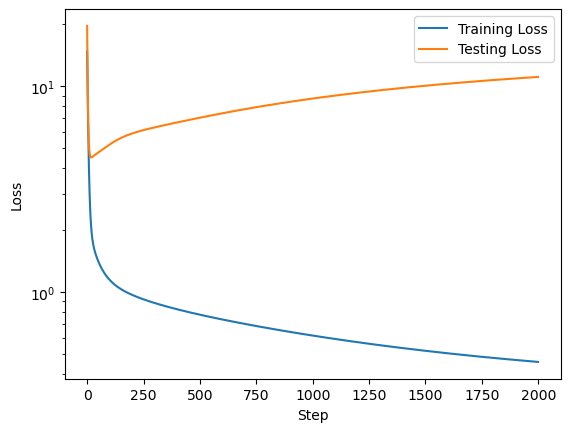

In [5]:
loss_progress = []
test_loss_progress = []
eta = 0.05
for i in range(2000):
    grad = loss_grad(w, b, x, y)
    w -= eta * grad[0]
    b -= eta * grad[1]
    loss_progress.append(loss(w, b, x, y))
    test_loss_progress.append(loss(w, b, test_x, test_y))
plt.plot(loss_progress, label="Training Loss")
plt.plot(test_loss_progress, label="Testing Loss")

plt.xlabel("Step")
plt.yscale("log")
plt.legend()
plt.ylabel("Loss")
plt.show()

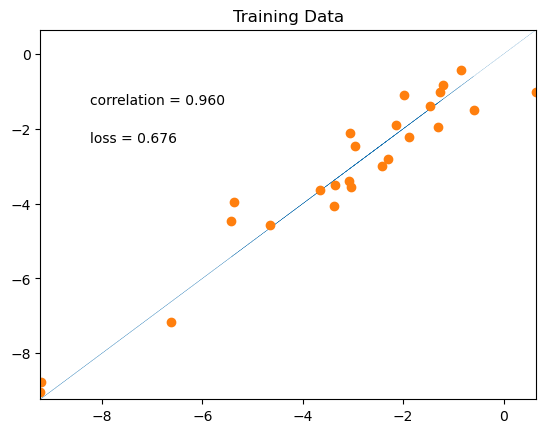

In [6]:
yhat = x @ w + b
plt.plot(y, y, ":", linewidth=0.2)
plt.plot(y, x @ w + b, "o")
plt.xlim(min(y), max(y))
plt.ylim(min(y), max(y))
plt.text(min(y) + 1, max(y) - 2, f"correlation = {np.corrcoef(y, yhat)[0,1]:.3f}")
plt.text(min(y) + 1, max(y) - 3, f"loss = {np.sqrt(np.mean((y - yhat)**2)):.3f}")
plt.title("Training Data")
plt.show()

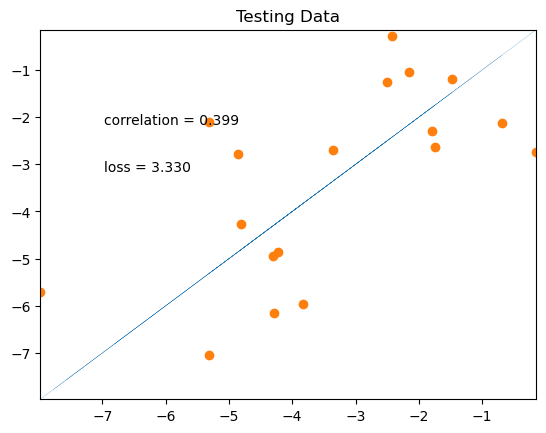

In [7]:
yhat = test_x @ w + b
plt.plot(test_y, test_y, ":", linewidth=0.2)
plt.plot(test_y, yhat, "o")
plt.xlim(min(test_y), max(test_y))
plt.ylim(min(test_y), max(test_y))
plt.text(
    min(test_y) + 1,
    max(test_y) - 2,
    f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",
)
plt.text(
    min(test_y) + 1,
    max(test_y) - 3,
    f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}",
)
plt.title("Testing Data")
plt.show()